In [1]:
import torch
import torch.nn as nn

In [2]:
class PINN_Schdger(nn.Module):
    def __init__(self):
        super(PINN_Schdger,self).__init__()
        #layer definitions
#        self.FC1 = nn.Linear(2,100)
#        self.FC2 = nn.Linear(100,100)
#        self.FC3 = nn.Linear(100,100)
#        self.FC4 = nn.Linear(100,100)
#        self.FC5 = nn.Linear(100,2)
        self.FC1 = nn.Linear(2,50)
        self.FC2 = nn.Linear(50,50)
        self.FC3 = nn.Linear(50,50)
        self.FC4 = nn.Linear(50,50)
        self.FC5 = nn.Linear(50,2)
        self.tanh = nn.Tanh()

    def forward(self, x, t):
        xt = torch.cat((x,t),1)
        x1 = self.FC1(xt)
        x1 = self.tanh(x1)
        x2 = self.FC2(x1)
        x2 = self.tanh(x2)
        x3 = self.FC3(x2)
        x3 = self.tanh(x3)
        x4 = self.FC4(x3)
        x4 = self.tanh(x4)
        x5 = self.FC5(x4)
        return x5

    # loss function
    def MSE(self,ypred,ytrue):
        return torch.mean((ypred - ytrue)**2) 

    # Glorot initialization of weight matrix
    def glorot_init_mat(self,shape):
        din = shape[0]
        dout = shape[1]
        var = torch.tensor([2.0/(din+dout)])
        std = torch.sqrt(var)
        mean = torch.tensor([0.0])
        dist = torch.distributions.normal.Normal(mean, std)
        return dist.sample(shape)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyDOE import lhs
import argparse
import scipy.io

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--epochs", help="Number of epochs to train neural network for")

"""data prep"""
"""
DE: u_t+0.5*v_{xx}+g*v=0
    v_t-0.5*u_{xx}-g*u=0
g = \sqrt{u^2+v^2}
"""
args = parser.parse_args(['--epochs','1000'])

In [17]:
data = scipy.io.loadmat('Data/NLS.mat')
    
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

In [18]:
N0,N_b,N_f = 50,50,4000
# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
# Generate samples for x, t
#sample points
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
    
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

idx_star = 0
t_star = t[idx_star,:]+0*x
#t_star = 0.79+0*x
h_star = Exact_h[:,idx_star]  

X_f = lb + (ub-lb)*lhs(2, N_f)

In [7]:
# %%
# Generate samples for x, t, u [boundary initial conditions]
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)

In [8]:

"""NN class, init, loss functions, dataloader"""

# %%
"""training process"""

# %%
#load u v
Exact_u = torch.tensor(Exact_u).type(torch.FloatTensor)
Exact_v = torch.tensor(Exact_v).type(torch.FloatTensor)
Exact_h = torch.tensor(Exact_h).type(torch.FloatTensor)
#load initial condition data
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
UV0 = torch.cat((u0,v0),1)
# load x, t data into torch
x0 = x0.reshape((-1, 1))
x0 = torch.tensor(x0).type(torch.FloatTensor)
tb = tb.reshape((-1, 1))
tb = torch.tensor(tb).type(torch.FloatTensor)

X0 = torch.tensor(X0).type(torch.FloatTensor)
X_lb = torch.tensor(X_lb).type(torch.FloatTensor)
X_ub = torch.tensor(X_ub).type(torch.FloatTensor)
X_f = torch.tensor(X_f).type(torch.FloatTensor)

In [9]:
# %%
#Instantiate class
pn = PINN_Schdger()

#Initialize weights
#Glorot initialization
[W, b] = list(pn.FC1.parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.FC2.parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.FC3.parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.FC4.parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.FC5.parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

tensor([0., 0.])

In [10]:
# %%
# Perform backprop
MAX_EPOCHS = int(args.epochs)
LRATE = 3e-4

#Use Adam for training
optimizer = torch.optim.Adam(pn.parameters(), lr=LRATE)

loss_history_bc = []
loss_history_ic = []
loss_history_f = []
loss_history = []

In [11]:
import time
start_time = time.time()
for epoch in range(MAX_EPOCHS):
    xc = x0.clone()
    tc = tb.clone()
    #full batch

    #initial condition
    UV0_pred = pn(xc,0*xc)
    mse_ic = pn.MSE(UV0_pred, UV0)
    loss_history_ic.append([epoch, mse_ic])
    
    #boundary condition
    x_lbc = X_lb[:,0:1].clone()
    x_lbc.requires_grad = True
    x_ubc = X_ub[:,0:1].clone()
    x_ubc.requires_grad = True
    UVub_pred = pn(x_ubc,tc)
    UVub_pred1 = torch.autograd.grad(UVub_pred.sum(),x_ubc,create_graph=True)[0]
    UVlb_pred = pn(x_lbc,tc)
    UVlb_pred1 = torch.autograd.grad(UVlb_pred.sum(),x_lbc,create_graph=True)[0]
    mse_bc = pn.MSE(UVub_pred, UVlb_pred)
    mse_bc += pn.MSE(UVub_pred1, UVlb_pred1)
    loss_history_bc.append([epoch, mse_bc])

    #f
    x_f = X_f[:,0:1].clone()
    x_f.requires_grad = True
    t_f = X_f[:,1:2].clone()
    t_f.requires_grad = True
    UV = pn(x_f,t_f)
    U = UV[:,0:1]
    V = UV[:,1:2]
    Ut = torch.autograd.grad(U.sum(),t_f,create_graph=True)[0]
    Ux = torch.autograd.grad(U.sum(),x_f,create_graph=True)[0]
    Uxx = torch.autograd.grad(Ux.sum(),x_f,create_graph=True)[0]
    Vt = torch.autograd.grad(V.sum(),t_f,create_graph=True)[0]
    Vx = torch.autograd.grad(V.sum(),x_f,create_graph=True)[0]
    Vxx = torch.autograd.grad(Vx.sum(),x_f,create_graph=True)[0]
    D = U**2+V**2
    F1 = Ut+0.5*Vxx+ D*V
    F2 = Vt-0.5*Uxx-D*U
    F = torch.cat((F1,F2),1)
    mse_f = pn.MSE(F, torch.zeros(F.shape)) #rescale f before computing loss
    loss_history_f.append([epoch, mse_f])

    loss = mse_ic + mse_bc + mse_f
    loss_history.append([epoch, loss])

    #optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print("Epoch: {}, MSE_ic: {:.4f}, MSE_bc: {:.4f}, MSE_f: {:.4f}, MSE: {:.4f}".format((epoch+1), mse_ic, mse_bc, mse_f, loss))
elapsed = time.time() - start_time

Epoch: 1000, MSE_ic: 0.0124, MSE_bc: 0.0005, MSE_f: 0.0148, MSE: 0.0277
Epoch: 2000, MSE_ic: 0.0089, MSE_bc: 0.0002, MSE_f: 0.0126, MSE: 0.0218
Epoch: 3000, MSE_ic: 0.0074, MSE_bc: 0.0003, MSE_f: 0.0110, MSE: 0.0187
Epoch: 4000, MSE_ic: 0.0067, MSE_bc: 0.0002, MSE_f: 0.0101, MSE: 0.0169
Epoch: 5000, MSE_ic: 0.0061, MSE_bc: 0.0001, MSE_f: 0.0091, MSE: 0.0153
Epoch: 6000, MSE_ic: 0.0057, MSE_bc: 0.0001, MSE_f: 0.0083, MSE: 0.0140


In [12]:
elapsed

418.5947251319885

In [13]:
#%%
#save trained model
fname = "PINN_Schdger_{}.pt".format(N_f)
torch.save(pn, fname)

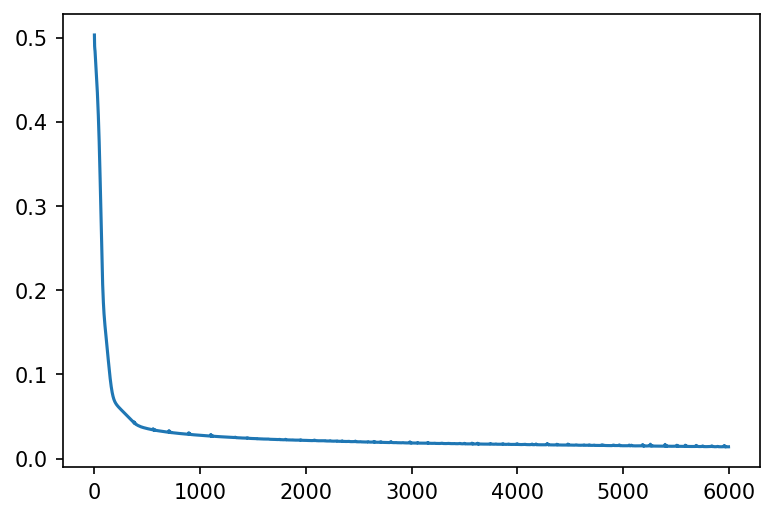

In [14]:
#%%
loss_history = np.array(loss_history)
plt.figure(dpi=150)
plt.plot(loss_history[:,0], loss_history[:,1])
plt.savefig("PINN_Schdger_loss_hist_{}.png".format(N_f))
#plt.show()

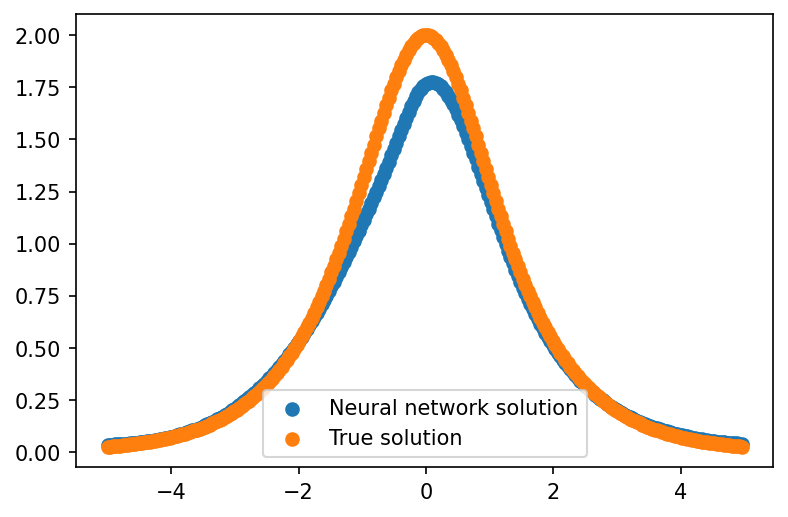

In [20]:
#%%
plt.figure(dpi=150)
x = torch.tensor(x).type(torch.FloatTensor)
t_star = torch.tensor(t_star).type(torch.FloatTensor)
UV_pred = pn(x,t_star)
u_pred = UV_pred[:,0:1]
v_pred = UV_pred[:,1:2]
h_pred = (u_pred**2+v_pred**2).sqrt()
plt.scatter(x.data.numpy(), h_pred.data.numpy(), label="Neural network solution")
plt.scatter(x.data.numpy(), h_star, label="True solution")
plt.legend()
plt.savefig("PINN_soln_comp_{}.png".format(N_f))
#plt.show()